# 慈善机构精准营销案例

#### 背景：有一个老兵社会组织主要通过发短信和邮寄小礼物的形式募集善款。为了减少成本，该组织决定仅向最优可能提供捐款的人发放信件和礼物。目前该组织有350万条历史营销记录，其中详细记录了营销信息与响应结果。该组织最感兴趣的是最近12-24个月有过捐款行为的人，并希望通过数据分析完成以下两个任务：确定什么人更有可能称为潜在的捐款人：确定这类人中个人的捐款数额可能是多少

#### 需构造二阶段模型,即使用二元逻辑回归预测响应率和线性模型预测潜在消费能力

#### 打开donations.csv，分别使用逻辑回归和线性回归构建多元回归模型，要确定的两个因变量分别是TargetB(Target Gift Flag)和TargetD(Target Gift Amount)。ID为该表的主键,每个取值代表一个观测;其余均为解释变量。接下来我们就开始分析数据并进行建模,此次我们遵循SEMMA建模步骤。

## 1.构造营销响应模型(二分类)

### 1.1数据获取与导入的S(抽样)阶段

In [232]:
#导入数据

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


data=pd.read_csv('donations.csv').drop(["ID","TARGET_D"],1)
data.head()

,TARGET_B,GiftCnt36,GiftCntAll,GiftCntCard36,GiftCntCardAll,GiftAvgLast,GiftAvg36,GiftAvgAll,GiftAvgCard36,GiftTimeLast,...,PromCntCardAll,StatusCat96NK,StatusCatStarAll,DemCluster,DemAge,DemGender,DemHomeOwner,DemMedHomeValue,DemPctVeterans,DemMedIncome
0,0,2,4,1,3,17.0,13.50,9.25,17.00,21,...,13,A,0,0,NaN,F,U,0,0,0
1,0,1,8,0,3,20.0,20.00,15.88,NaN,26,...,24,A,0,23,67.0,F,U,186800,85,0
2,1,6,41,3,20,6.0,5.17,3.73,5.00,18,...,22,S,1,0,NaN,M,U,87600,36,38750
3,1,3,12,3,8,10.0,8.67,8.50,8.67,9,...,16,E,1,0,NaN,M,U,139200,27,38942
4,0,1,1,1,1,20.0,20.00,20.00,20.00,21,...,6,F,0,35,53.0,M,U,168100,37,71509


In [233]:
#设置变量及因变量

data.dtypes
y = 'TARGET_B'
var_c = ["GiftCnt36","GiftCntAll","GiftCntCard36",
         "GiftCntCardAll","GiftTimeLast","GiftTimeFirst",
         "PromCnt12","PromCnt36","PromCntAll",
         "PromCntCard12","PromCntCard36","PromCntCardAll",
         "DemAge","DemMedHomeValue",
         "DemPctVeterans","DemMedIncome","GiftAvgLast",
         "GiftAvg36","GiftAvgAll","GiftAvgCard36"]
var_d = ['StatusCat96NK', 'DemHomeOwner', 'DemGender', 'StatusCatStarAll','DemCluster']
X = data[var_c + var_d].copy()
Y = data[y].copy()

In [234]:
#根据IV值筛选变量 - 分类变量：

from woe import WoE

iv_d = {}
for i in var_d:
    iv_d[i] = WoE(v_type='d').fit(X[i].copy(), Y.copy()).iv
pd.Series(iv_d).sort_values(ascending = False)

#以2%作为选取变量的阀值，保留前三个IV值较高的变量。
var_d_s = ['StatusCatStarAll','StatusCat96NK', 'DemCluster']
#var_d_s = ['StatusCat96NK', 'DemCluster']

In [235]:
#根据IV值筛选变量-连续变量：

iv_c = {}
for i in var_c:
    iv_c[i] = WoE(v_type='c',t_type='b',qnt_num=3).fit(X[i],Y).iv 
sort_iv_c = pd.Series(iv_c).sort_values(ascending=False)
sort_iv_c

#以2%作为选取变量的阀值，保留IV值较高的变量。
var_c_s=list(sort_iv_c[sort_iv_c>0.02].index)
var_c_s

['GiftAvgCard36',
 'GiftCnt36',
 'GiftAvg36',
 'GiftAvgAll',
 'GiftCntAll',
 'GiftAvgLast',
 'GiftCntCardAll',
 'GiftTimeLast',
 'PromCntCard36',
 'PromCntAll',
 'GiftTimeFirst',
 'PromCntCardAll']

### 1.2针对每个变量的E(探索)阶段

In [236]:
#检查连续变量的分布情况
X = data[var_c_s + var_d_s].copy()
Y = data[y].copy()
X[var_c_s].describe().T

,count,mean,std,min,25%,50%,75%,max
GiftAvgCard36,7906.0,14.224431,10.022710,1.33,8.67,12.50,18.0,260.0
GiftCnt36,9686.0,3.205451,2.133421,0.00,2.00,3.00,4.0,16.0
GiftAvg36,9686.0,14.876203,10.057007,0.00,9.60,13.50,18.5,260.0
GiftAvgAll,9686.0,12.489325,9.209297,1.50,7.75,10.71,15.0,450.0
GiftCntAll,9686.0,10.507640,8.993401,1.00,4.00,8.00,15.0,91.0
GiftAvgLast,9686.0,16.017739,12.041805,0.00,10.00,15.00,20.0,450.0
GiftCntCardAll,9686.0,5.582490,4.736894,0.00,2.00,4.00,8.0,41.0
GiftTimeLast,9686.0,18.002168,4.073549,4.00,16.00,18.00,20.0,27.0
PromCntCard36,9686.0,11.954677,4.571568,2.00,7.00,13.00,16.0,28.0
PromCntAll,9686.0,48.483481,23.061483,5.00,29.00,48.00,65.0,174.0


In [237]:
#利用众数减去中位数的差值除以四分位距来查找是否有可能存在异常值

abs((X[var_c_s].mode().iloc[0,] - X[var_c_s].median()) /
    (X[var_c_s].quantile(0.75) - X[var_c_s].quantile(0.25)))

GiftAvgCard36     0.267953
GiftCnt36         0.500000
GiftAvg36         0.168539
GiftAvgAll        0.591724
GiftCntAll        0.636364
GiftAvgLast       0.000000
GiftCntCardAll    0.500000
GiftTimeLast      0.000000
PromCntCard36     0.444444
PromCntAll        0.972222
GiftTimeFirst     0.391304
PromCntCardAll    0.285714
dtype: float64

(array([3.860e+02, 8.910e+02, 1.310e+03, 1.076e+03, 1.063e+03, 1.055e+03,
        1.395e+03, 1.140e+03, 7.950e+02, 2.490e+02, 9.800e+01, 8.500e+01,
        5.300e+01, 4.200e+01, 2.900e+01, 1.200e+01, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  5.  ,  13.45,  21.9 ,  30.35,  38.8 ,  47.25,  55.7 ,  64.15,
         72.6 ,  81.05,  89.5 ,  97.95, 106.4 , 114.85, 123.3 , 131.75,
        140.2 , 148.65, 157.1 , 165.55, 174.  ]),
 <a list of 20 Patch objects>)

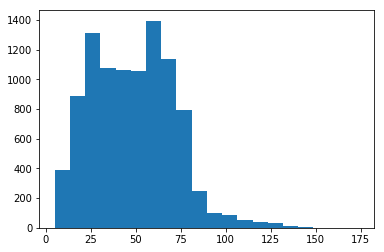

In [238]:
#众数偏离中位数的程度大于0.8就很值得怀疑了，所以我们需要绘制该变量的直方图查看具体情况
plt.hist(X["PromCntAll"], bins=20)#发现只是出现双峰，没有太大问题，不需要修改

In [239]:
#通过频次表和取值分布来查看分类变量的分布

for i in var_d_s:
    print(i,len(X[i].value_counts()))

print('-'*40)
for i in var_d_s:
    print(X[i].value_counts())
    print('-'*40)

StatusCatStarAll 2
StatusCat96NK 6
DemCluster 54
----------------------------------------
1    5236
0    4450
Name: StatusCatStarAll, dtype: int64
----------------------------------------
A    5826
S    2365
F     660
N     574
E     227
L      34
Name: StatusCat96NK, dtype: int64
----------------------------------------
40    432
24    401
36    401
35    384
27    331
49    323
12    323
18    321
13    309
30    262
14    248
39    242
0     240
11    236
45    228
43    227
51    220
16    201
41    197
46    196
28    194
2     191
44    185
8     182
17    178
10    175
20    171
21    165
53    158
3     153
42    140
25    135
34    132
23    131
22    125
31    125
1     121
38    118
15    108
26    100
37     99
48     96
5      95
47     86
7      78
29     73
32     72
50     70
9      70
6      53
33     52
4      51
19     50
52     32
Name: DemCluster, dtype: int64
----------------------------------------


### 1.3针对有问题的变量进行修改的M(修改)阶段

#### 变量修改需要完成三个任务:1.纠正错误值;2.补充被解释变量的缺失值;3.变量分布调整，连续变量调整为正态分布,分类变量进行概化处理。

##### 1.3.1 连续变量的修改

In [240]:
#通过上一步分析没有发现连续变量有错误值,不需要修改,于是使用下列语句计算缺失值

#查看缺失比例

1 - (X.describe().T["count"]) / len(X)

#用中位数进行填补
fill_GiftAvgCard36 = X.GiftAvgCard36.median()
X.GiftAvgCard36.fillna(value=fill_GiftAvgCard36, inplace=True)

##### 1.3.2 分类变量的修改

In [241]:
#DemCluster变量分类过多，转换为虚拟变量会使模型过于复杂，在此我们先对DemCluster进行取值归约，然后再进行WOE转换
DemCluster_grp = data[['DemCluster','TARGET_B']].groupby('DemCluster',as_index = False)
DemC_C = DemCluster_grp['TARGET_B'].agg({'mean' : 'mean','count':'count'}).sort_values("mean")
DemC_C["count_cumsum"] = DemC_C["count"].cumsum()
DemC_C["new_DemCluster"] = DemC_C["count_cumsum"].apply(lambda x: x//(len(data)/10))
DemC_C["new_DemCluster"] = DemC_C["new_DemCluster"].astype(int)
Dem=dict(DemC_C["new_DemCluster"])
Dem

{32: 0,
 10: 0,
 47: 0,
 44: 0,
 52: 0,
 6: 0,
 30: 0,
 41: 1,
 37: 1,
 8: 1,
 21: 1,
 43: 1,
 49: 2,
 51: 2,
 45: 2,
 36: 3,
 25: 3,
 15: 3,
 17: 3,
 9: 3,
 5: 3,
 12: 3,
 31: 4,
 48: 4,
 33: 4,
 50: 4,
 19: 4,
 27: 4,
 26: 4,
 14: 5,
 39: 5,
 34: 5,
 16: 5,
 2: 5,
 22: 5,
 42: 6,
 18: 6,
 35: 6,
 46: 7,
 11: 7,
 24: 7,
 23: 7,
 20: 8,
 40: 8,
 29: 8,
 38: 8,
 13: 8,
 1: 9,
 3: 9,
 53: 9,
 28: 9,
 7: 9,
 0: 9,
 4: 9}

In [242]:
#WOE转换
X_rep = X.copy()
X_rep['DemCluster']=X_rep.DemCluster.map(Dem).astype(int)#使用归约，分数0.6189
#var_d_s_=['StatusCat96NK', 'DemCluster']
var_d_s_=['StatusCat96NK']
for i in var_d_s_:X_rep[i+"_woe"] = WoE(v_type='d').fit_transform(X_rep[i],Y)
StatusCat96NK_woe = X_rep[["StatusCat96NK","StatusCat96NK_woe"]].drop_duplicates().set_index("StatusCat96NK").to_dict()
#DemCluster_woe = X_rep[["DemCluster","DemCluster_woe"]].drop_duplicates().set_index("DemCluster").to_dict()#使用woe转换分数0.6170
#StatusCatStarAll_woe = X_rep[["StatusCatStarAll","StatusCatStarAll_woe"]].drop_duplicates().set_index("StatusCatStarAll").to_dict()
del X_rep["StatusCat96NK"]
#del X_rep["DemCluster"]
#del X_rep["StatusCatStarAll"]
#X_rep.rename(columns={"StatusCat96NK_woe":"StatusCat96NK","DemCluster_woe":"DemCluster","StatusCatStarAll_woe":"StatusCatStarAll"},inplace=True)
X_rep.rename(columns={"StatusCat96NK_woe":"StatusCat96NK"},inplace=True)
X_rep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9686 entries, 0 to 9685
Data columns (total 15 columns):
GiftAvgCard36       9686 non-null float64
GiftCnt36           9686 non-null int64
GiftAvg36           9686 non-null float64
GiftAvgAll          9686 non-null float64
GiftCntAll          9686 non-null int64
GiftAvgLast         9686 non-null float64
GiftCntCardAll      9686 non-null int64
GiftTimeLast        9686 non-null int64
PromCntCard36       9686 non-null int64
PromCntAll          9686 non-null int64
GiftTimeFirst       9686 non-null int64
PromCntCardAll      9686 non-null int64
StatusCatStarAll    9686 non-null int64
DemCluster          9686 non-null int32
StatusCat96NK       9686 non-null float64
dtypes: float64(5), int32(1), int64(9)
memory usage: 1.1 MB


In [63]:
'''
#将StatusCatStarAll转换为虚拟变量
t = pd.get_dummies(X_rep['StatusCatStarAll'],prefix='StatusCatStarAll')
X_rep = pd.concat([X_rep,t[:len(X_rep)]],axis=1)
X_rep.drop('StatusCatStarAll',axis=1,inplace=True)
X_rep.head()
'''

,GiftAvgCard36,GiftCnt36,GiftAvg36,GiftAvgAll,GiftCntAll,GiftAvgLast,GiftCntCardAll,GiftTimeLast,PromCntCard36,PromCntAll,GiftTimeFirst,PromCntCardAll,StatusCat96NK,DemCluster,StatusCatStarAll_0,StatusCatStarAll_1
0,17.00,2,13.50,9.25,4,17.0,3,21,8,26,66,13,-0.081748,-0.287682,1,0
1,12.50,1,20.00,15.88,8,20.0,3,26,5,79,92,24,-0.081748,-0.287682,1,0
2,5.00,6,5.17,3.73,41,6.0,20,18,11,51,111,22,0.335458,-0.693147,0,1
3,8.67,3,8.67,8.50,12,10.0,8,9,6,44,93,16,0.328925,-0.287682,0,1
4,20.00,1,20.00,20.00,1,20.0,1,21,7,13,21,6,-0.449860,-0.287682,1,0


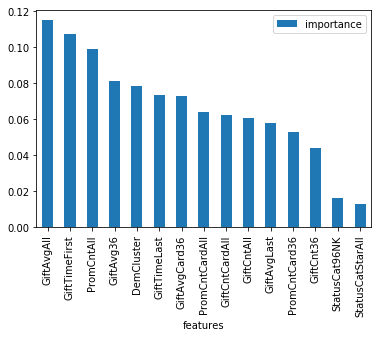

In [243]:

#通过随机森林对变量的重要性进行筛选:

import sklearn.ensemble as ensemble
rfc = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=3, max_features=0.5, min_samples_split=5)
rfc_model = rfc.fit(X_rep, Y)
rfc_model.feature_importances_
rfc_fi = pd.DataFrame()
rfc_fi["features"] = list(X_rep.columns)
rfc_fi["importance"] = list(rfc_model.feature_importances_)
rfc_fi=rfc_fi.set_index("features",drop=True)
var_sort = rfc_fi.sort_values(by="importance",ascending=False)
var_sort.plot(kind="bar")



##### 1.3.3 解释变量的分布转换

In [244]:
var_x = list(var_sort.importance[var_sort.importance > 0.02].index)
var_x

['GiftAvgAll',
 'GiftTimeFirst',
 'PromCntAll',
 'GiftAvg36',
 'DemCluster',
 'GiftTimeLast',
 'GiftAvgCard36',
 'PromCntCardAll',
 'GiftCntCardAll',
 'GiftCntAll',
 'GiftAvgLast',
 'PromCntCard36',
 'GiftCnt36']

In [245]:
#查看每个变量的偏度,按照降序排列好
skew_var_x = {}
for i in var_x:
    skew_var_x[i] = abs(X_rep[i].skew())  
skew = pd.Series(skew_var_x).sort_values(ascending=False)
skew


GiftAvgAll        14.486489
GiftAvgLast        9.918893
GiftAvgCard36      6.747117
GiftAvg36          5.627792
GiftCntAll         1.863109
GiftCntCardAll     1.331353
GiftCnt36          1.288353
GiftTimeLast       0.778047
PromCntAll         0.460765
PromCntCard36      0.426600
GiftTimeFirst      0.195399
PromCntCardAll     0.142856
DemCluster         0.041157
dtype: float64

In [246]:
#将偏度大于1的变量进行对数运算

var_x_ln = skew.index[skew > 1]
for i in var_x_ln:
    if min(X_rep[i]) <= 0:
        X_rep[i] =np.log(X_rep[i] + abs(min(X_rep[i])) + 0.01)
    else:
        X_rep[i] =np.log(X_rep[i])


##### 1.3.4 变量压缩



In [247]:
from VarSelec import Var_Select,Var_Select_auto
X_rep_reduc = Var_Select_auto(X_rep)
X_rep_reduc.head()

[Int64Index([11], dtype='int64'), Int64Index([3], dtype='int64'), Int64Index([1], dtype='int64'), Int64Index([13], dtype='int64'), Int64Index([7], dtype='int64'), Int64Index([8], dtype='int64'), Int64Index([14], dtype='int64')]


,PromCntCardAll,GiftAvgAll,GiftCnt36,DemCluster,GiftTimeLast,PromCntCard36,StatusCat96NK
0,13,2.224624,0.698135,9,21,8,-0.081748
1,24,2.765060,0.009950,7,26,5,-0.081748
2,22,1.316408,1.793425,9,18,11,0.335458
3,16,2.140066,1.101940,9,9,6,0.328925
4,6,2.995732,0.009950,6,21,7,-0.449860


### 1.4建立逻辑回归模型的M(建模)阶段



In [248]:
#分成训练集和测试集
import sklearn.model_selection as model_selection
ml_data = model_selection.train_test_split(X_rep_reduc, Y, test_size=0.3, random_state=0)
train_data, test_data, train_target, test_target = ml_data
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
train_data = min_max_scaler.fit_transform(train_data)
test_data = min_max_scaler.fit_transform(test_data)
train_data

array([[0.0754717 , 0.41186546, 0.62549207, ..., 0.82608696, 0.19230769,
        0.36830594],
       [0.56603774, 0.29686366, 0.81236781, ..., 0.7826087 , 0.5       ,
        0.46874294],
       [0.26415094, 0.27614939, 0.71876242, ..., 0.65217391, 0.15384615,
        0.46874294],
       ...,
       [0.50943396, 0.24889435, 0.77349058, ..., 0.56521739, 0.42307692,
        0.46874294],
       [0.41509434, 0.23302698, 0.77349058, ..., 0.52173913, 0.42307692,
        0.46874294],
       [0.16981132, 0.55425089, 0.71876242, ..., 0.82608696, 0.42307692,
        0.46874294]])

In [249]:
#网格搜索与lasso相结合,寻找最优模型

import sklearn.linear_model as linear_model
logistic_model = linear_model.LogisticRegression(class_weight = None,
                                                 dual = False,
                                                 fit_intercept = True,
                                                 intercept_scaling = 1,
                                                 penalty = 'l1',
                                                 random_state = None,
                                                 tol = 0.001)

from sklearn.model_selection import ParameterGrid, GridSearchCV
C = np.logspace(-3,0,20,base=10)
param_grid = {'C': C}
clf_cv = GridSearchCV(estimator=logistic_model, 
                      param_grid=param_grid, 
                      cv=5, 
                      scoring='roc_auc')
clf_cv.fit(train_data, train_target)

#得到最优参数，并将这个参数再次带入之前预定义的逻辑回归对象进行模型参数估计

logistic_model = linear_model.LogisticRegression(C=clf_cv.best_params_["C"],
                                                 class_weight=None,
                                                 dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 penalty='l1',
                                                 random_state=None,
                                                 tol=0.001)
logistic_model.fit(train_data, train_target)




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.001, verbose=0, warm_start=False)

In [250]:
logistic_model.coef_

array([[-0.11648627, -1.58455043,  0.86085768,  0.56988548, -0.82862817,
         0.2125685 ,  0.27984388]])

#### 1.1.5 模型的A(验证)阶段

AUC = 0.6201


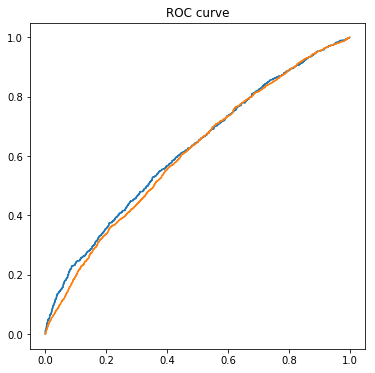

In [251]:
test_est = logistic_model.predict(test_data)
train_est = logistic_model.predict(train_data)
test_est_p = logistic_model.predict_proba(test_data)[:,1]
train_est_p = logistic_model.predict_proba(train_data)[:,1]
import sklearn.metrics as metrics
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train)
plt.title('ROC curve')
print('AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))

#### 1.1.6 模型的优化阶段

##### 我们结合了其它的分类算法对模型打分，最后发现逻辑回归是在此模型表现最好的算法，并且我们发现不使用参数调优反而准确率分数稍高，不过模型的评分才0.6170，这是个不太好的结果，需要我们后期进一步的优化。

In [252]:

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train_data, train_target)
Y_pred = logreg.predict(test_data)
acc_log = round(logreg.score(train_data, train_target) * 100, 2)
print('logreg',acc_log)
# Support Vector Machines

svc = SVC()
svc.fit(train_data, train_target)
Y_pred = svc.predict(test_data)
acc_svc = round(svc.score(train_data, train_target) * 100, 2)
acc_svc
print('svc',acc_svc)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_data, train_target)
Y_pred = knn.predict(test_data)
acc_knn = round(knn.score(train_data, train_target) * 100, 2)
print('knn',acc_knn)

# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train_data, train_target)
Y_pred = gaussian.predict(test_data)
acc_gaussian = round(gaussian.score(train_data, train_target) * 100, 2)
print('gaussian',acc_gaussian)

# Perceptron

perceptron = Perceptron()
perceptron.fit(train_data, train_target)
Y_pred = perceptron.predict(test_data)
acc_perceptron = round(perceptron.score(train_data, train_target) * 100, 2)
print('perceptron',acc_perceptron)

# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(train_data, train_target)
Y_pred = linear_svc.predict(test_data)
acc_linear_svc = round(linear_svc.score(train_data, train_target) * 100, 2)
print('linear_svc',acc_linear_svc)

# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(train_data, train_target)
Y_pred = sgd.predict(test_data)
acc_sgd = round(sgd.score(train_data, train_target) * 100, 2)
print('sgd',acc_sgd)

# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_data, train_target)
Y_pred = decision_tree.predict(test_data)
acc_decision_tree = round(decision_tree.score(train_data, train_target) * 100, 2)
print('decision_tree',acc_decision_tree)

# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_data, train_target)
Y_pred = random_forest.predict(test_data)
random_forest.score(train_data, train_target)
acc_random_forest = round(random_forest.score(train_data, train_target) * 100, 2)
print('random_forest',acc_random_forest)


logreg 57.94
svc 57.36
knn 77.32
gaussian 57.37
perceptron 50.29
linear_svc 57.91
sgd 53.44
decision_tree 98.73
random_forest 98.73


AUC = 0.6206


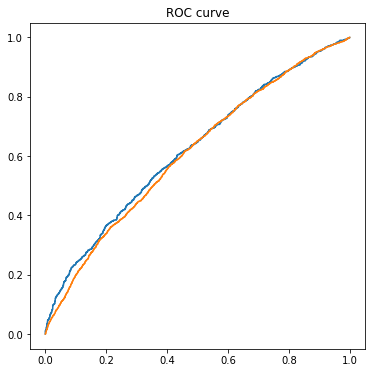

In [253]:
test_est = logreg.predict(test_data)
train_est = logreg.predict(train_data)
test_est_p = logreg.predict_proba(test_data)[:,1]
train_est_p = logreg.predict_proba(train_data)[:,1]
import sklearn.metrics as metrics
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train)
plt.title('ROC curve')
print('AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))

In [264]:
X_rep_reduc = min_max_scaler.fit_transform(X_rep_reduc)
X_rep_reduc_ = logreg.predict(X_rep_reduc)
X_rep_reduc_p = logreg.predict_proba(X_rep_reduc)[:,1]

In [269]:

result=pd.DataFrame([X_rep_reduc_p],index=['predict']).T
result.to_csv('result1.csv')